In [ ]:
#1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 80
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = True,
                                             transform = transform,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = False,
                                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 100,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 100,
                                           shuffle = False)

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.maxpool = nn.MaxPool2d(4)
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc = nn.Linear(1568, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = VGG().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def train(epoch):
  total_step = len(train_loader)
  curr_lr = learning_rate
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(i + 1) % 100 == 0:
      print("Epoch [{} / {}], Step [{} / {}], Loss : {:4f}".format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

  if(epoch + 1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

def test():
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images : {}%'.format(100 * correct / total))

for epoch in range(num_epochs):
  train(epoch)
  test()

100%|██████████| 170498071/170498071 [00:02<00:00, 77527326.34it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Epoch [1 / 80], Step [100 / 500], Loss : 1.977144
Epoch [1 / 80], Step [200 / 500], Loss : 1.657457
Epoch [1 / 80], Step [300 / 500], Loss : 1.663981
Epoch [1 / 80], Step [400 / 500], Loss : 1.659177
Epoch [1 / 80], Step [500 / 500], Loss : 1.514905
Accuracy of the model on the test images : 47.49%
Epoch [2 / 80], Step [100 / 500], Loss : 1.497679
Epoch [2 / 80], Step [200 / 500], Loss : 1.613864
Epoch [2 / 80], Step [300 / 500], Loss : 1.552642
Epoch [2 / 80], Step [400 / 500], Loss : 1.520850
Epoch [2 / 80], Step [500 / 500], Loss : 1.433418
Accuracy of the model on the test images : 53.57%
Epoch [3 / 80], Step [100 / 500], Loss : 1.483878
Epoch [3 / 80], Step [200 / 500], Loss : 1.279629
Epoch [3 / 80], Step [300 / 500], Loss : 1.370525
Epoch [3 / 80], Step [400 / 500], Loss : 1.356339
Epoch [3 / 80], Step [500 / 500], Loss : 1.389059
Accuracy of the model on the test images : 57.19%
Epoch [4 / 80], Step [100 / 500], Loss : 

In [4]:
#2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 80
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = True,
                                             transform = transform,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = False,
                                             transform = transforms.ToTensor())

temp_ = np.array([temp.numpy() for temp, _ in train_dataset])

train_mean_r = np.mean(temp_, axis = (2, 3))[:, 0].mean()
train_mean_g = np.mean(temp_, axis = (2, 3))[:, 1].mean()
train_mean_b = np.mean(temp_, axis = (2, 3))[:, 2].mean()

train_std_r = np.std(temp_, axis = (2, 3))[:, 0].std()
train_std_g = np.std(temp_, axis = (2, 3))[:, 1].std()
train_std_b = np.std(temp_, axis = (2, 3))[:, 2].std()

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((train_mean_r, train_mean_g, train_mean_b), (train_std_r, train_std_g, train_std_b))])

train_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = True,
                                             transform = transform)

test_dataset = torchvision.datasets.CIFAR10(root = '../../data',
                                             train = False,
                                             transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 100,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 100,
                                           shuffle = False)

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.maxpool = nn.MaxPool2d(4)
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc = nn.Linear(1568, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = VGG().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def train(epoch):
  total_step = len(train_loader)
  curr_lr = learning_rate
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(i + 1) % 100 == 0:
      print("Epoch [{} / {}], Step [{} / {}], Loss : {:4f}".format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

  if(epoch + 1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

def test():
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images : {}%'.format(100 * correct / total))

for epoch in range(num_epochs):
  train(epoch)
  test()

Files already downloaded and verified
Epoch [1 / 80], Step [100 / 500], Loss : 1.653235
Epoch [1 / 80], Step [200 / 500], Loss : 1.661620
Epoch [1 / 80], Step [300 / 500], Loss : 1.415728
Epoch [1 / 80], Step [400 / 500], Loss : 1.211463
Epoch [1 / 80], Step [500 / 500], Loss : 1.108979
Accuracy of the model on the test images : 54.91%
Epoch [2 / 80], Step [100 / 500], Loss : 1.240216
Epoch [2 / 80], Step [200 / 500], Loss : 1.311013
Epoch [2 / 80], Step [300 / 500], Loss : 1.299161
Epoch [2 / 80], Step [400 / 500], Loss : 1.175692
Epoch [2 / 80], Step [500 / 500], Loss : 1.271825
Accuracy of the model on the test images : 59.37%
Epoch [3 / 80], Step [100 / 500], Loss : 1.175050
Epoch [3 / 80], Step [200 / 500], Loss : 1.359568
Epoch [3 / 80], Step [300 / 500], Loss : 1.119724
Epoch [3 / 80], Step [400 / 500], Loss : 1.104466
Epoch [3 / 80], Step [500 / 500], Loss : 1.103122
Accuracy of the model on the test images : 60.29%
Epoch [4 / 80], Step [100 / 500], Loss : 1.056507
Epoch [4 / 8

In [ ]:
#3
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 80
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = True,
                                             transform = transform,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = False,
                                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 100,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 100,
                                           shuffle = False)

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(2304, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = VGG().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def train(epoch):
  total_step = len(train_loader)
  curr_lr = learning_rate
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(i + 1) % 100 == 0:
      print("Epoch [{} / {}], Step [{} / {}], Loss : {:4f}".format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

  if(epoch + 1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

def test():
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images : {}%'.format(100 * correct / total))

for epoch in range(num_epochs):
  train(epoch)
  test()

Files already downloaded and verified
Epoch [1 / 80], Step [100 / 500], Loss : 4.457411
Epoch [1 / 80], Step [200 / 500], Loss : 4.437878
Epoch [1 / 80], Step [300 / 500], Loss : 4.294033
Epoch [1 / 80], Step [400 / 500], Loss : 4.033851
Epoch [1 / 80], Step [500 / 500], Loss : 3.878910
Accuracy of the model on the test images : 7.54%
Epoch [2 / 80], Step [100 / 500], Loss : 3.584479
Epoch [2 / 80], Step [200 / 500], Loss : 3.907220
Epoch [2 / 80], Step [300 / 500], Loss : 3.601439
Epoch [2 / 80], Step [400 / 500], Loss : 3.630270
Epoch [2 / 80], Step [500 / 500], Loss : 3.575439
Accuracy of the model on the test images : 15.27%
Epoch [3 / 80], Step [100 / 500], Loss : 3.648129
Epoch [3 / 80], Step [200 / 500], Loss : 3.311726
Epoch [3 / 80], Step [300 / 500], Loss : 3.556444
Epoch [3 / 80], Step [400 / 500], Loss : 3.520103
Epoch [3 / 80], Step [500 / 500], Loss : 3.700214
Accuracy of the model on the test images : 21.25%
Epoch [4 / 80], Step [100 / 500], Loss : 3.492326
Epoch [4 / 80

Files already downloaded and verified
Epoch [1 / 10], Step [100 / 500], Stride 1 Loss : 4.351306, Stride 2 Loss : 4.411368
Epoch [1 / 10], Step [200 / 500], Stride 1 Loss : 4.243219, Stride 2 Loss : 4.054534
Epoch [1 / 10], Step [300 / 500], Stride 1 Loss : 4.192564, Stride 2 Loss : 4.206045
Epoch [1 / 10], Step [400 / 500], Stride 1 Loss : 3.834022, Stride 2 Loss : 3.943064
Epoch [1 / 10], Step [500 / 500], Stride 1 Loss : 3.833245, Stride 2 Loss : 3.853319
Accuracy of the model on the test images / Stride 1 : 11.1%, Stride 2 : 8.95%
Epoch [2 / 10], Step [100 / 500], Stride 1 Loss : 4.015233, Stride 2 Loss : 3.970945
Epoch [2 / 10], Step [200 / 500], Stride 1 Loss : 3.803619, Stride 2 Loss : 3.918461
Epoch [2 / 10], Step [300 / 500], Stride 1 Loss : 3.888881, Stride 2 Loss : 3.787602
Epoch [2 / 10], Step [400 / 500], Stride 1 Loss : 3.872915, Stride 2 Loss : 3.698504
Epoch [2 / 10], Step [500 / 500], Stride 1 Loss : 3.704359, Stride 2 Loss : 3.565212
Accuracy of the model on the test 

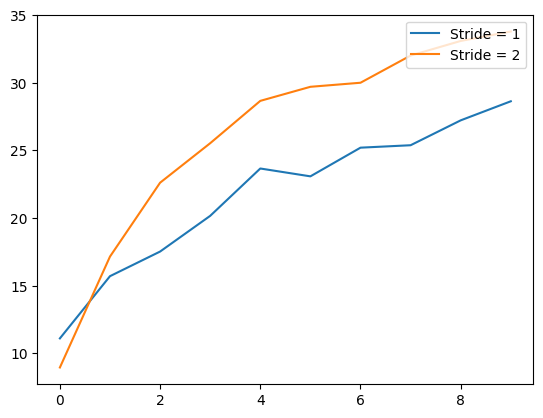

In [19]:
#4 - 1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = True,
                                             transform = transform,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = False,
                                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 100,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 100,
                                           shuffle = False)

class VGG1(nn.Module):
  def __init__(self):
    super(VGG1, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 1)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(82944, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

class VGG2(nn.Module):
  def __init__(self):
    super(VGG2, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(2304, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model1 = VGG1().to(device)
model2 = VGG2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def train(epoch):
  total_step = len(train_loader)
  curr_lr = learning_rate
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs1 = model1(images)
    outputs2 = model2(images)
    loss1 = criterion(outputs1, labels)
    loss2 = criterion(outputs2, labels)

    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    if(i + 1) % 100 == 0:
      print("Epoch [{} / {}], Step [{} / {}], Stride 1 Loss : {:4f}, Stride 2 Loss : {:4f}".format(epoch + 1, num_epochs, i + 1, total_step, loss1.item(), loss2.item()))

  if(epoch + 1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer1, curr_lr)
    update_lr(optimizer2, curr_lr)

def test():
  model1.eval()
  model2.eval()
  with torch.no_grad():
    correct1 = 0
    correct2 = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs1 = model1(images)
      outputs2 = model2(images)
      _, predicted1 = torch.max(outputs1.data, 1)
      _, predicted2 = torch.max(outputs2.data, 1)
      total += labels.size(0)
      correct1 += (predicted1 == labels).sum().item()
      correct2 += (predicted2 == labels).sum().item()

    print('Accuracy of the model on the test images / Stride 1 : {}%, Stride 2 : {}%'.format(100 * correct1 / total, 100 * correct2 / total))

    accuracy_val1.append(100 * correct1 / total)
    accuracy_val2.append(100 * correct2 / total)

epoch_val = []
accuracy_val1 = []
accuracy_val2 = []

for epoch in range(num_epochs):
  epoch_val.append(epoch)
  train(epoch)
  test()

plt.plot(epoch_val, accuracy_val1, label = 'Stride = 1')
plt.plot(accuracy_val2, label = 'Stride = 2')
plt.legend(loc = 'upper right')
plt.show()

Files already downloaded and verified
Epoch [1 / 10], Step [100 / 500], In 64 Out 256 Loss : 4.267036, In 128 Out 256 Loss : 4.401844, In 128 Out 512 Loss : 4.600831
Epoch [1 / 10], Step [200 / 500], In 64 Out 256 Loss : 4.216385, In 128 Out 256 Loss : 4.213704, In 128 Out 512 Loss : 4.606266
Epoch [1 / 10], Step [300 / 500], In 64 Out 256 Loss : 4.212058, In 128 Out 256 Loss : 4.118310, In 128 Out 512 Loss : 4.607040
Epoch [1 / 10], Step [400 / 500], In 64 Out 256 Loss : 3.943056, In 128 Out 256 Loss : 3.780996, In 128 Out 512 Loss : 4.606113
Epoch [1 / 10], Step [500 / 500], In 64 Out 256 Loss : 3.956922, In 128 Out 256 Loss : 3.798334, In 128 Out 512 Loss : 4.606224
Accuracy of the model on the test images / In 64 Out 256 : 9.62%, In 128 Out 256 : 12.05%, In 128 Out 512 : 1.0%
Epoch [2 / 10], Step [100 / 500], In 64 Out 256 Loss : 3.656721, In 128 Out 256 Loss : 3.476170, In 128 Out 512 Loss : 4.607979
Epoch [2 / 10], Step [200 / 500], In 64 Out 256 Loss : 3.952259, In 128 Out 256 L

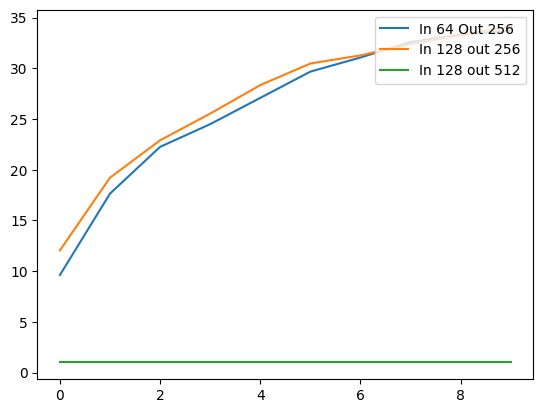

In [5]:
#4 - 2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = True,
                                             transform = transform,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR100(root = '../../data',
                                             train = False,
                                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 100,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 100,
                                           shuffle = False)

class VGG64_256(nn.Module):
  def __init__(self):
    super(VGG64_256, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(2304, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

class VGG128_256(nn.Module):
  def __init__(self):
    super(VGG128_256, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(2304, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

class VGG128_512(nn.Module):
  def __init__(self):
    super(VGG128_512, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.conv1_b2 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, stride = 1)
    self.conv2_b2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1)
    self.conv1_b3 = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 3, stride = 1)
    self.conv2_b3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1)
    self.relu = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(4608, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.relu(self.conv1_b2(x))
    x = self.relu(self.conv2_b2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv1_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.relu(self.conv2_b3(x))
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model64_256 = VGG64_256().to(device)
model128_256 = VGG128_256().to(device)
model128_512 = VGG128_512().to(device)

criterion = nn.CrossEntropyLoss()
optimizer64_256 = torch.optim.Adam(model64_256.parameters(), lr = learning_rate)
optimizer128_256 = torch.optim.Adam(model128_256.parameters(), lr = learning_rate)
optimizer128_512 = torch.optim.Adam(model128_512.parameters(), lr = learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def train(epoch):
  total_step = len(train_loader)
  curr_lr = learning_rate
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs64_256 = model64_256(images)
    outputs128_256 = model128_256(images)
    outputs128_512 = model128_512(images)
    loss64_256 = criterion(outputs64_256, labels)
    loss128_256 = criterion(outputs128_256, labels)
    loss128_512 = criterion(outputs128_512, labels)

    optimizer64_256.zero_grad()
    loss64_256.backward()
    optimizer64_256.step()

    optimizer128_256.zero_grad()
    loss128_256.backward()
    optimizer128_256.step()

    optimizer128_512.zero_grad()
    loss128_512.backward()
    optimizer128_512.step()

    if(i + 1) % 100 == 0:
      print("Epoch [{} / {}], Step [{} / {}], In 64 Out 256 Loss : {:4f}, In 128 Out 256 Loss : {:4f}, In 128 Out 512 Loss : {:4f}".format(epoch + 1, num_epochs, i + 1, total_step, loss64_256.item(), loss128_256.item(), loss128_512.item()))

  if(epoch + 1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer64_256, curr_lr)
    update_lr(optimizer128_256, curr_lr)
    update_lr(optimizer128_512, curr_lr)

def test():
  model64_256.eval()
  model128_256.eval()
  model128_512.eval()
  with torch.no_grad():
    correct64_256 = 0
    correct128_256 = 0
    correct128_512 = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs64_256 = model64_256(images)
      outputs128_256 = model128_256(images)
      outputs128_512 = model128_512(images)
      _, predicted64_256 = torch.max(outputs64_256.data, 1)
      _, predicted128_256 = torch.max(outputs128_256.data, 1)
      _, predicted128_512 = torch.max(outputs128_512.data, 1)
      total += labels.size(0)
      correct64_256 += (predicted64_256 == labels).sum().item()
      correct128_256 += (predicted128_256 == labels).sum().item()
      correct128_512 += (predicted128_512 == labels).sum().item()

    print('Accuracy of the model on the test images / In 64 Out 256 : {}%, In 128 Out 256 : {}%, In 128 Out 512 : {}%'.format(100 * correct64_256 / total, 100 * correct128_256 / total, 100 * correct128_512 / total))

  accuracy_val64_256.append(100 * correct64_256 / total)
  accuracy_val128_256.append(100 * correct128_256 / total)
  accuracy_val128_512.append(100 * correct128_512 / total)

epoch_val = []
accuracy_val64_256 = []
accuracy_val128_256 = []
accuracy_val128_512 = []

for epoch in range(num_epochs):
  epoch_val.append(epoch)
  train(epoch)
  test()

plt.plot(epoch_val, accuracy_val64_256, label = 'In 64 Out 256')
plt.plot(accuracy_val128_256, label = 'In 128 out 256')
plt.plot(accuracy_val128_512, label = 'In 128 out 512')
plt.legend(loc = 'upper right')
plt.show()